# Supervised Learning Method Outline

---



## Data Preprocessing

### 1. Loading Data
- Load the MIMIC-IV dataset (hosp, icu, notes).

### 2. Feature Selection
- Select relevant features based on the defined digital phenotype.

### 3. Data Cleaning
- Remove outliers, handle missing data, and other noise.

### 4. Data Normalisation
- Standardise the scales for numerical features.
- Impute missing values particularly for important features

### 5. Label Encoding/Categorisation
- Convert categorical features to numerical values if needed.

### 6. Natural Language Processing (NLP)
- Extract and categorise insights from clinical notes.

### 7. Balance Datasets
- Handle significant class imbalance using Upsampling/Downsampling techniques
- E.g. SMOTE, class_weight

### 8. Train-Test Split
- Partition the dataset into training and testing sets.
- Stratify datasets

---

## Model Building

### 1. Model Selection
- Choose appropriate machine learning model(s) (e.g., Decision Trees, Random Forest, SVM).

### 2. Hyperparameter Tuning
- Fine-tune model hyperparameters using techniques like GridSearch or RandomSearch.

### 3. Feature Importance
- Evaluate and rank the importance of each feature.

### 4. Model Training
- Train the selected model on the training dataset.

---

## Model Evaluation

### 1. Validation Metrics
- Define metrics for evaluation (e.g., accuracy, precision, recall, F1-score).

### 2. Cross-Validation
- Apply cross-validation to assess model performance.

### 3. Performance Metrics
- Compute performance metrics on the testing set.

### 4. Confusion Matrix
- Generate a confusion matrix to evaluate class-wise performance.

### 5. ROC Curve
- Evaluate the Receiver Operating Characteristic (ROC) curve.

---


# Model Imports

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# User options: 'Will', 'Chinatip'
# USER = "Will"
USER = "Will"

# Set up environment variables
if USER == 'Will':
    project_id = 'eighth-arbor-396212'
elif USER == 'Chinatip':
    project_id = 'ml-health-application'
else:
    project_id = None # FILL IN HERE

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


## Select All Patient Features

In [ ]:
BIG_QUERY = False

if BIG_QUERY:
    query = "SELECT * FROM `comp90089-hai-patients.hai_patients.patient_cohort_features` limit 3000"
    data = run_query(query)
else:
    from google.colab import drive
    drive.mount('/content/drive')

    file_path = ''
    if USER == 'Will':
        file_path = '/content/drive/My Drive/Colab Notebooks/COMP90089 Group Project Data/patient_cohort_features_vap.csv'
    data = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning

In [ ]:
def check_null():
  #Check missing values
  print(data.isnull().sum(),"\n\n")

  #Check the type of data for each column. Notice that 'gender' is categorical (object) and 'dod' is time series.
  print(data.info())
check_null()

subject_id                             0
hadm_id                                0
stay_id                                0
duration_from_vap_device            7990
type__s__cmv                        7990
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 277, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 277 entries, subject_id to vent_o2_device-tracheostomy_tube
dtypes: float64(258), int64(2), object(17)
memory usage: 57.0+ MB
None


## Drop Columns

In [ ]:
import pandas as pd
from datetime import datetime

def is_datetime_col(series, sample_size=100):
    """Check if a pandas Series contains datetime-like values."""
    sample = series.dropna().sample(min(sample_size, series.count()))
    for item in sample:
        try:
            # Try to convert to datetime object
            datetime.strptime(str(item), '%Y-%m-%d %H:%M:%S %Z')
        except ValueError:
            return False
    return True

# Assume 'data' is your DataFrame
datetime_cols = []
for col in data.columns:
    if is_datetime_col(data[col]):
        datetime_cols.append(col)

# Drop datetime columns
data = data.drop(columns=datetime_cols)

print(f"Dropped the following datetime columns: {datetime_cols}")

Dropped the following datetime columns: ['abnormal_procalcitonin', 'abnormal_oxygen_levels_from_vap_lab', 'abnormal_wbc_count_from_vap_lab', 'belowavr_wbc_count_from_vap_lab', 'aboveavr_wbc_count_from_vap_lab', 'abnormal_c_reactive_protein_from_vap_lab', 'abnormal_procalcitonin_from_vap_lab', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']


In [ ]:
data.drop(['subject_id', 'hadm_id', 'stay_id', 'stay_id_1', 'admit_provider_id'], axis=1, inplace=True)


In [ ]:
# #drop records with unknown race and gender
# data = data[data['race'] != 'Unknown']
# data = data[data['gender'] != None]


# # Fill missing value with mean values
# data.fillna(data.mean(), inplace=True)
# data

In [ ]:
# Iterate over columns and apply the prefix and fill NaN with replacement value
for col in data.columns:
    if col.startswith("type_"):
        data[col].fillna(0, inplace=True)
check_null()

duration_from_vap_device            7990
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 53.5+ MB
None


In [ ]:
# drop na and duplicate records
# data = data.dropna()
data = data.drop_duplicates()

# Remove na records
check_null()

duration_from_vap_device            4816
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        4257
vent_o2_device-nasal_cannula        4257
vent_o2_device-t-piece              4257
vent_o2_device-trach_mask_          4257
vent_o2_device-tracheostomy_tube    4257
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17860 entries, 0 to 26968
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 35.6+ MB
None


## Data Normalisation & Label Encoding/Categorisation

In [ ]:
type_df = data.applymap(type)

string_columns = []
for col in type_df.columns:
    if (type_df[col] == str).any():
        string_columns.append(col)

print(f"Columns with at least one string element: {string_columns}")

Columns with at least one string element: ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'gender', 'anchor_year_group', 'dod', 'HAI_category']


#### Transform DOD Feature

In [ ]:
data['died'] = data['dod'].notna()

data.drop('dod', axis=1, inplace=True)

### Label Encoding

In [ ]:
data = pd.get_dummies(data, columns=['admission_type', 'race', 'gender', 'insurance', 'admission_type', 'admission_location', 'discharge_location', 'language', 'marital_status', 'anchor_year_group'])

# Create a LabelEncoder instance
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# fill missing value with mean
data.fillna(data.mean(), inplace=True)

<ipython-input-25-baf6b1632119>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


### Data Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

X = data.drop("HAI_category", axis=1)
y = data["HAI_category"]

# Fit and transform the scaler on the DataFrame
X_normalised = scaler.fit_transform(X)

# Create a new DataFrame with the normalized values
X_normalised = pd.DataFrame(X_normalised, columns=X.columns)

# Model Building

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalised, y, test_size=0.2, random_state=42, stratify=y)

### Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

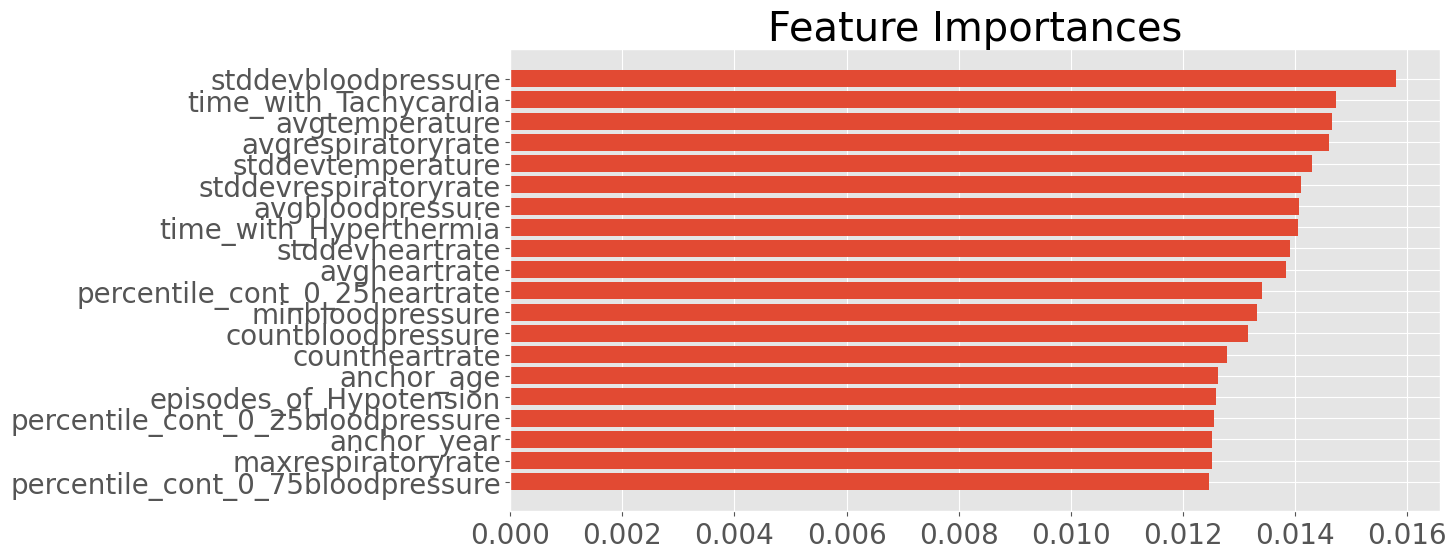

90                            stddevbloodpressure
83                          time_with_Tachycardia
111                                avgtemperature
99                             avgrespiratoryrate
114                             stddevtemperature
                          ...                    
294                            insurance_Medicaid
328                      discharge_location_REHAB
316      admission_location_WALK-IN/SELF REFERRAL
332                       marital_status_DIVORCED
304    admission_type_SURGICAL SAME DAY ADMISSION
Name: feature, Length: 160, dtype: object

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for the importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame by the importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.gca().invert_yaxis()
plt.show()

# You can choose to keep only the most important features based on a certain threshold or top N features
important_features = feature_importances[feature_importances['importance'] > 0.001]['feature']
X_reduced = X[important_features]
important_features

### Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    # Predict the labels
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the final model: {accuracy:.2f}')

    # Compute the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
    print(f'Multi-class ROC-AUC score: {roc_auc:.2f}')

    # Print classification report
    print(classification_report(y_test, y_pred))


Accuracy of the final model: 0.75
Multi-class ROC-AUC score: 0.53
              precision    recall  f1-score   support

           0       0.56      0.09      0.15       926
           1       0.75      0.98      0.85      2646

    accuracy                           0.75      3572
   macro avg       0.66      0.53      0.50      3572
weighted avg       0.70      0.75      0.67      3572



In [ ]:
from sklearn.ensemble import RandomForestClassifier

le = LabelEncoder()

# Fit and transform the labels
y_encoded = le.fit_transform(y)

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y_encoded, test_size=0.2, random_state=42, stratify=y)

RandomForestClassifier(random_state=42)

## Baseline Model
Accuracy: 0.72
ROC-AUC: 0.65

In [ ]:
final_rf = RandomForestClassifier(n_estimators=100, random_state=42)

final_rf.fit(X_train_reduced, y_train)

y_pred = final_rf.predict(X_test_reduced)

evaluate_model(final_rf, X_test_reduced, y_test)


Accuracy of the final model: 0.75
Multi-class ROC-AUC score: 0.53
              precision    recall  f1-score   support

           0       0.56      0.09      0.15       926
           1       0.75      0.98      0.85      2646

    accuracy                           0.75      3572
   macro avg       0.66      0.53      0.50      3572
weighted avg       0.70      0.75      0.67      3572



### SMOTE Model

In [ ]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)

# Fit the model
final_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_smote.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = final_rf_smote.predict(X_test_reduced)

evaluate_model(final_rf_smote, X_test_reduced, y_test)


Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.56
              precision    recall  f1-score   support

           0       0.49      0.19      0.28       926
           1       0.77      0.93      0.84      2646

    accuracy                           0.74      3572
   macro avg       0.63      0.56      0.56      3572
weighted avg       0.70      0.74      0.69      3572



### Class Weight Model

In [ ]:
# Assign higher weight to class 0
class_weights = {0: 5, 1: 1}

final_rf_weighted = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
final_rf_weighted.fit(X_train_reduced, y_train)

# Evaluate the model
y_pred = final_rf_weighted.predict(X_test_reduced)

evaluate_model(final_rf_weighted, X_test_reduced, y_test)


Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.53
              precision    recall  f1-score   support

           0       0.53      0.09      0.15       926
           1       0.75      0.97      0.85      2646

    accuracy                           0.74      3572
   macro avg       0.64      0.53      0.50      3572
weighted avg       0.69      0.74      0.67      3572



## TODO:

- SMOTE/UnderSampling
- Class Weights
- Cross Validation
- Hyperparameter Tuning

---

- Test features with and without non-predictive features e.g. high temperature
- Separating each HAI
- Ensemble / Boosting
- Separate our feature spaces, predict on each and then do a weighted vote
- Shift focus to Predicting if patient HAS a HAI vs if a patient is at RISK of HAI. Focus on if the patient has ALREADY CONTRACTED HAI


### RandomForest

In [ ]:
def train_model(X, y, target, use_gradient = False):
  # Initialize a classifier (Random Forest in this example)
  clf = random_forest_classifier = RandomForestClassifier(
      n_estimators=100,  # Number of trees in the forest
      max_depth=None,    # Maximum depth of the trees (set to None for unlimited depth)
      random_state=42    # Random seed for reproducibility
  )

  if use_gradient:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

  # Initialize RFE with your classifier
  rfe = RFE(estimator=clf, step=1)

  # Instantiate SMOTE
  smote = SMOTE(random_state=42)

  # Apply SMOTE to the dataset
  X_resampled, y_resampled = smote.fit_resample(X, y)

  # Assuming you have a DataFrame 'df' with an imbalanced target variable 'target'
  # Separate the majority and minority classes
  majority_class = data[data[target] == 0]
  minority_class = data[data[target] == 1]

  # Downsample the majority class to match the number of minority class samples
  majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

  # Combine the minority class with the downsampled majority class
  balanced_df = pd.concat([minority_class, majority_downsampled])

  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print("Check the subsets size: X_train:{}, y_train:{}, X_test:{}, y_test:{}. \n\n".format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

  # Set the optimal number of features for RFE
  # rfe.n_features_to_select = get_optimal_num_features(rfe, X_train, y_train)
  rfe.n_features_to_select = 12 # above line took too long

  # Fit RFE on the training data
  rfe.fit(X_train, y_train)

  # After fitting RFE, you can access the selected features
  selected_features = X_train.columns[rfe.support_]

  # Print the selected feature names
  print("Selected Features:")
  print(selected_features)

  # Create a new DataFrame with only the selected features
  X_train_selected = X_train[X_train.columns[rfe.support_]]
  X_test_selected = X_test[X_train.columns[rfe.support_]]

  # Train your final model using the selected features
  # Calculate class weights
  class_weights = dict(zip([0, 1], (len(y_train) - y_train.sum()) / (2 * np.bincount(y_train))))

  clf.class_weight = class_weights
  clf.fit(X_train_selected, y_train)

  # Make predictions on the test data using the final model
  y_pred = clf.predict(X_test_selected)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)

  # Print the accuracy
  print(f"Accuracy: {accuracy:.2f}")